## Tuning facebook:wav2vec2-large-960h

Here, we finetune the facebook:wav2vec2-large-960h model from huggingface using the `cv-valid-train` common_voice dataset.

## Table of Contents

1. [Summary](#Summary)
2. [Imports and helpers](#Imports-and-helpers)
3. [Pre-processing](#Pre-processing)
    1. [Convert mp3 to wav](#Convert-mp3-to-wav)
    2. [Clean data](#Clean-data)
    3. [Create datasets](#Create-datasets)
    4. [Tokenize labels](#Tokenize-labels)
4. [Model Finetuning](#Model-Finetuning)
   1. [Configuration](#Configuration)
   2. [Baseline WER](#Baseline-WER)
   3. [Training](#Training)
5. [Evaluation - cv-valid-test](#Evaluation---cv-valid-test)
6. [Evaluation - cv-valid-dev](#Evaluation---cv-valid-dev)

### Summary

lorem ipsum

__Assumptions__:
1. Cloned repo placed in user's home directory
2. Common voice folder located at `~/asr_project/common_voice`

### Imports and helpers

In [1]:
# Imports
import os
import re
import random
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
import gc
from multiprocessing import Pool, cpu_count

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Audio as PlayAudio

from accelerate import Accelerator
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor
from transformers import TrainingArguments, Trainer
from datasets import load_dataset, Audio, DatasetDict, load_from_disk, Dataset
import evaluate

import torch
from torch.utils.data import DataLoader
import torchaudio
from transformers import get_linear_schedule_with_warmup
from torch.utils.tensorboard import SummaryWriter
from torch.optim import AdamW
from torch.amp import autocast, GradScaler
from tqdm import tqdm

from pydub import AudioSegment
import soundfile as sf
from mutagen import File

from jiwer import wer

HOME_DIR = os.path.expanduser('~')

/home/tfc/anaconda3/envs/asr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# Helpers
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

# Remove <s> and </s> tags from both ends of each string
def remove_start_end_tags(texts):
    return [re.sub(r"^<s>|</s>$", "", text) for text in texts]

def remove_start_end_tags_batch(batch):
    # Remove the <s> and </s> tags from both ends of each string in 'pred_str' and 'text'
    batch["pred_str"] = re.sub(r"^<s>|</s>$", "", batch["pred_str"])
    batch["text"] = re.sub(r"^<s>|</s>$", "", batch["text"])
    return batch

### Pre-processing

Data pre-processing for the [common voice](https://www.dropbox.com/scl/fi/i9yvfqpf7p8uye5o8k1sj/common_voice.zip?rlkey=lz3dtjuhekc3xw4jnoeoqy5yu&dl=0) dataset follows the steps below, heeding wav2vec2 model's expected input format:
1. Convert mp3 to wav
2. Clean data - remove problematic data points with longer than expected audio clip durations. These long audio clips will otherwise create memory issues.
3. Create dataset with `input_values` and `labels` columns
4. Tokenize transcript

In [3]:
# File directories
audio_or_dir = os.path.join(
    HOME_DIR,
    'asr_project/common_voice/cv-valid-train/')                 # Audio clips
audio_dir = os.path.join(
    HOME_DIR,
    'asr_project/common_voice/cv-valid-train/cv-valid-train/')  # Audio clips
audioloc_transcript_or_dir = os.path.join(
    HOME_DIR,
    'asr_project/common_voice/cv-valid-train.csv')              # Original csv with transcript, filenames, and other info
audioloc_transcript_dir = os.path.join(
    HOME_DIR,
    'asr_project/asr-train/selected_transcript.csv')            # csv with processed transcripts and filenames, and other info
temp_dir = os.path.join(
    HOME_DIR,
    'asr_project/asr-train/temp.csv')                           # Temporary csv with only processed transcripts and filenames

#### 1. Convert mp3 to wav

We begin with conversion from mp3 to wav.

In [4]:
# Function to convert mp3 to wav
def convert_mp3_to_wav(mp3_file):
    # Generate the output wav file path
    wav_file = mp3_file.replace('.mp3', '.wav')
    
    # Convert mp3 to wav if wav file does not exist
    if not os.path.exists(wav_file):
        waveform, sample_rate = torchaudio.load(mp3_file)
        torchaudio.save(wav_file, waveform, sample_rate)
    
    return wav_file

# Read in original transcript and filename csv file
df_transcript = pd.read_csv(audioloc_transcript_or_dir)

# Convert mp3 to wav. Change mp3 file extension in filename accordingly
df_transcript['filename'] = df_transcript['filename'].apply(
    lambda filename: convert_mp3_to_wav(
        os.path.join(audio_or_dir, filename)))

# Put texts to uppercase to match model requirements
df_transcript['text'] = df_transcript['text'].str.upper()
df_transcript['filename'] = df_transcript['filename'].map(lambda x: os.path.basename(x))

# Save a copy of processed df
df_transcript.to_csv(audioloc_transcript_dir)

#### 2. Clean data

Next, we checking the audio files for outliers or problematic data points.

In [5]:
# Function to retrieve audio characteristics
def get_audio_info(file_path):
    # Extract filename and extension
    file_name, file_ext = os.path.splitext(os.path.basename(file_path))
    file_size = os.path.getsize(file_path)  # Size in bytes

    # Get audio length with mutagen
    try:
        audio = File(file_path)
        audio_length = audio.info.length if audio and audio.info else None
    except Exception as e:
        print(f"Could not process file {file_name}: {e}")
        audio_length = None

    return {
        'filename': file_name,
        'extension': file_ext,
        'size_bytes': file_size,
        'length_seconds': audio_length
    }

# Function to get audio characteristics of all audio files in given directory.
def process_directory(directory):
    # List all audio files in directory
    audio_files = [
        os.path.join(directory, f) for f in os.listdir(directory) 
        if os.path.isfile(os.path.join(directory, f))
    ]

    with Pool(cpu_count()) as pool:
        # Wrap audio files list with tqdm for progress bar
        audio_info = list(tqdm(pool.imap(get_audio_info, audio_files), total=len(audio_files), desc="Processing files"))

    # Create DataFrame from the list of dictionaries
    df = pd.DataFrame(audio_info)
    return df

# Get audio file information.
audio_df = process_directory(audio_dir)

# mutagen unable to get audio clip durations from wav files, so we get them from their mp3 counterparts
audio_df_mp3 = audio_df.loc[audio_df['extension']=='.mp3'].copy()
audio_df_wav = audio_df.loc[audio_df['extension']=='.wav'].copy().drop(columns=['length_seconds'])
audio_df_wav = audio_df_wav.merge(audio_df_mp3[['filename','length_seconds']], on='filename', how='left')
audio_df_wav['filename'] = audio_df_wav['filename'].map(lambda x: x+'.wav')
audio_df_wav.head()

Processing files: 100%|██████████| 391552/391552 [00:16<00:00, 23443.34it/s]


,filename,extension,size_bytes,length_seconds
0,sample-183811.wav,.wav,198222,2.064
1,sample-004348.wav,.wav,428622,4.464
2,sample-145859.wav,.wav,525390,5.472
3,sample-047541.wav,.wav,209742,2.184
4,sample-156913.wav,.wav,550734,5.736


We see that some audio clips have unexpected durations, more than 6 minutes long.

In [6]:
audio_df_wav.describe()

,size_bytes,length_seconds
count,1.957760e+05,195776.000000
mean,4.282028e+05,4.459634
std,2.468908e+05,2.571779
min,7.150200e+04,0.744000
25%,2.972940e+05,3.096000
50%,3.940620e+05,4.104000
75%,5.184780e+05,5.400000
max,3.774190e+07,393.144000


We check the transcripts to see if there are long transcripts that require 6 minutes to read.

In [7]:
# Get length of each transcript
df_transcript['len'] = df_transcript['text'].str.len()
df_transcript = df_transcript[['filename','len','text']]

# Find longest transcript in number of characters
filename_longest = df_transcript.loc[df_transcript['len']==df_transcript['len'].max(), 'filename'].item()
text_longest = df_transcript.loc[df_transcript['len']==df_transcript['len'].max(), 'text'].item()

print(f'Filename with longest transcript: {filename_longest}')
print(f'Longest transcript text: {text_longest}')

longest_clip_duration = audio_df_wav.loc[audio_df_wav['filename']==filename_longest,'length_seconds'].item()
print(f'Longest transcript duration: {longest_clip_duration}s')

Filename with longest transcript: sample-123772.wav
Longest transcript text: IN THE ROAD THAT RUNS FROM THE TOP OF PUTNEY HILL TO WIMBLEDON WAS A NUMBER OF POOR VESTIGES OF THE PANIC TORRENT THAT MUST HAVE POURED LONDONWARD ON THE SUNDAY NIGHT AFTER THE FIGHTING BEGAN
Longest transcript duration: 11.424s


The clip with the longest transcript is 11s long. Considering differences in reading speeds, we assume the longest legitimate script reading to be 15s long.

In [10]:
df_transcript = df_transcript.merge(audio_df_wav[['filename', 'length_seconds']], on='filename', how='left')
print(f'Number of audio clips with duration > 15s: {(df_transcript['length_seconds'] > 15).sum().item()}')
print(f'Number of audio clips with duration < 15s: {(df_transcript['length_seconds'] < 15).sum().item()}')

Number of audio clips with duration > 15s: 397
Number of audio clips with duration < 15s: 195378


We find 397 samples with durations >15s. __Dropping those would leave us with ~195k samples__. This will help prevent memory issues during model finetuning. We save a copy of this filtered dataset for later reference.

In [11]:
df_transcript = df_transcript.loc[df_transcript['length_seconds']<15].drop(columns=['len','length_seconds'])
df_transcript.to_csv(audioloc_transcript_dir, index=False)

#### 3. Create datasets

We create a `DatasetDict` for with 70-30 train-test split.

In [12]:
# Load csv file with wav filenames and complete filepaths
df = pd.read_csv(audioloc_transcript_dir)
df['filename'] = df['filename'].map(lambda x: os.path.join(audio_dir,x))
df.to_csv(temp_dir,index=False)

# Create dataset directly from csv
dataset = load_dataset('csv', data_files=temp_dir, split='train')
dataset = dataset.cast_column("filename",
                              Audio(sampling_rate=16000))         # Cast audio files with 16kHz sampling rate

# train-val 70-30 split
dataset = dataset.train_test_split(test_size=0.3, seed=42)        # Split to train-val

# Final, combined dataset
dataset = DatasetDict({
    'train': dataset['train'],
    'val': dataset['test']})

dataset

Generating train split: 195378 examples [00:00, 1312055.96 examples/s]


DatasetDict({
    train: Dataset({
        features: ['filename', 'text'],
        num_rows: 136764
    })
    val: Dataset({
        features: ['filename', 'text'],
        num_rows: 58614
    })
})

#### 4. Tokenize labels

We can now begin tokenizing the transcripts. Instead of creating our own, we will make use of the `facebook/wav2vec2-large-960h` model's tokenizers and processors in our finetuning efforts below. To do this, we need to:
1. Convert the transcripts to uppercase, which is already done earlier;
2. Insert start, end, and delimiter tokens, which we carry out below.

In [14]:
# Following the style of facebook/wav2ec2-large-960h model
start_token = "<s>"
end_token = "</s>"
word_delimiter_token = "|"

# Function to insert required tokens
def preprocess_transcript(batch):
    transcript = batch['text']
    
    # Replace multiple spaces with a single space
    transcript = re.sub(r'\s+', ' ', transcript)
    
    # Add start and end tokens, and replace spaces with '|'
    processed_transcript = start_token + transcript.replace(" ", f"{word_delimiter_token}") + end_token
    
    return {"processed_text": processed_transcript}

# Apply the preprocessing to both train and validation splits
dataset = dataset.map(preprocess_transcript, remove_columns=["text"],num_proc=4)

# Changing column names to `input_values` and `labels`
dataset = dataset.rename_column("filename", "input_values")
dataset = dataset.rename_column("processed_text", "labels")

Map (num_proc=4): 100%|██████████| 58614/58614 [00:00<00:00, 116285.36 examples/s]


Then, we tokenize the transcripts and use the `input_values` and `labels` column names in the datasets.

In [15]:
# Load processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

def prepare_dataset(batch):
    # Process 'input_values' column for 1D waveform values
    batch["input_values"] = processor(batch["input_values"]["array"],
                                      sampling_rate=16000).input_values[0]
    
    # Process the 'labels' column to create 'labels' (text data)
    batch["labels"] = processor(text=batch["labels"]).input_ids
    
    return batch

# Map the dataset transformation to both 'train' and 'val' splits
dataset = dataset.map(prepare_dataset, num_proc=2)


Map (num_proc=2): 100%|██████████| 58614/58614 [02:49<00:00, 346.73 examples/s]


In [ ]:
# Save the dataset to a directory for easy retrieval later.
dataset.save_to_disk("temp_dataset")

Before commencing training, we do a quick check of our data by playing a random audio file below...

In [17]:
rand_int = random.randint(0, len(dataset["train"]))
print(dataset["train"]["labels"][rand_int])

audio_data = dataset["train"][rand_int]["input_values"]
PlayAudio(data=audio_data, rate=16000)

[1, 14, 16, 13, 10, 9, 21, 4, 8, 9, 5, 4, 8, 20, 4, 6, 11, 5, 12, 5, 4, 19, 8, 9, 25, 5, 13, 12, 7, 6, 10, 8, 9, 12, 4, 6, 11, 5, 4, 14, 13, 10, 25, 5, 13, 4, 6, 8, 15, 14, 4, 8, 20, 4, 11, 10, 12, 4, 8, 18, 9, 4, 15, 10, 20, 5, 2]


... and check the data formats, e.g. 1-D waveform.

In [18]:
rand_int = random.randint(0, len(dataset["train"]))

print("Target (encoded) text:", dataset["train"][rand_int]["labels"])
print("Input array shape:", np.asarray(dataset["train"][rand_int]["input_values"]).shape)

Target (encoded) text: [1, 12, 11, 8, 16, 15, 14, 4, 10, 4, 16, 9, 14, 5, 13, 12, 6, 7, 9, 14, 4, 6, 11, 5, 4, 5, 17, 5, 13, 7, 15, 14, 4, 6, 7, 24, 15, 5, 6, 4, 6, 11, 5, 4, 24, 8, 22, 4, 7, 12, 26, 5, 14, 2]
Input array shape: (161664,)


Everything looks good!

### Model Finetuning

#### 1. Configuration

As elaborated [here](https://huggingface.co/blog/fine-tune-wav2vec2-english), a data collator with dynamic padding is more efficient for ASR applications considering the lengths of the input sequences. We adopt their data collator below.

In [ ]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

# Load processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

To benchmark our model's performance, we make use of the Word Error Rate (WER) metric.

In [ ]:
wer_metric = evaluate.load("wer")

# Function to calculate WER based on predicted vs ground truth.
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    # Replace padding token id with -100
    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    # Decode predictions and references
    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    # Remove the <s> and </s> tags from the decoded strings
    pred_str = remove_start_end_tags(pred_str)
    label_str = remove_start_end_tags(label_str)

    # Compute WER
    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

Finally, we load the pre-trained model, Freezing all layers but the head and the final 3 encoder layers.

In [20]:
# Load model
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-960h", 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the output layer (lm_head)
for param in model.lm_head.parameters():
    param.requires_grad = True

# Unfreeze last 3 encoder layers
for layer in model.wav2vec2.encoder.layers[-3:]:
    for param in layer.parameters():
        param.requires_grad = True

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


... and set up the trainer. We use HuggingFace `trainer` to simplify the training process. Based on a brief preliminary experimentation, we use the following settings.

1. Setting to reduce memory requirements and optimize GPU usage:
- `per_device_train_batch_size` and `per_device_eval_batch_size`: 16
- `gradient_accumulation_steps`: 4
- `gradient_checkpointing`: True
- `fp16` (mixed precision training): True

2. Settings for stable training:
- `warmup_steps`: 1000

3. Setting to optimize training speed:
- `dataloader_pin_memory`: True
- `dataloader_num_workers`: 4

In [ ]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir=os.path.expanduser('~/asr_project/asr-train/model_outputs'),
    logging_dir=os.path.expanduser('~/asr_project/asr-train/logs'),
    per_device_train_batch_size=16,              # Batch size for training
    per_device_eval_batch_size=16,               # Batch size for evaluation
    num_train_epochs=10,                         # Total number of training epochs
    logging_steps=250,                           # Log every 250 steps
    eval_strategy="steps",                       # Evaluate during training
    save_steps=500,                              # Save checkpoint every 500 steps
    eval_steps=500,                              # Evaluate every 500 steps
    warmup_steps=1000,
    load_best_model_at_end=True,                 # Load the best model at the end of training
    gradient_checkpointing=True,
    gradient_accumulation_steps=4,
    fp16=True,
    # optim="adamw_bnb_8bit",                    # adamw_apex_fused, adamw_bnb_8bit. did not help.
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
)

# Define huggingface trainer
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,             # As defined earlier, for WER calculation.
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    processing_class= processor.feature_extractor
)

#### 2. Baseline WER

As a benchmark against our model's performance, we first get a baseline WER using the `facebook:wav2vec2-large-960h` model before further finetuning.

In [ ]:
# Load dataset
dataset = load_from_disk("temp_dataset")

In [21]:
def map_to_result(batch):
    with torch.no_grad():
        input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
        logits = model(input_values).logits

    pred_ids = torch.argmax(logits, dim=-1)
    batch["pred_str"] = processor.batch_decode(pred_ids)[0]
    batch["text"] = processor.decode(batch["labels"], group_tokens=False)
  
    return batch

model.to('cuda')
results = dataset["val"].map(map_to_result, remove_columns=dataset["val"].column_names)

Parameter 'function'=<function map_to_result at 0x78b2bbf17b00> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Map: 100%|██████████| 58614/58614 [24:38<00:00, 39.64 examples/s]


In [24]:
# Remove start and end tags from predicted transcripts.
results = results.map(remove_start_end_tags_batch)

# Get WER
print("Baseline WER on validation set: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Map: 100%|██████████| 58614/58614 [00:00<00:00, 71828.49 examples/s]


Baseline WER on validation set: 0.105


We see that the model shows a WER of about 10.5% before finetuning. We will keep this in mind as we finetune the model.

#### 3. Training

We begin training.

In [ ]:
# Start training
result = trainer.train()

We visualize the training and validation loss, as well as the validation WER over time.

In [25]:
from tbparse import SummaryReader

log_dir = os.path.expanduser('~/asr_project/asr-train/logs')
reader = SummaryReader(log_dir)
df = reader.scalars
df.drop_duplicates(subset=['step','tag'], keep='last', inplace=True)
df = df.pivot(index='step', columns='tag', values='value').reset_index()
df_eval = df.loc[~pd.isna(df['eval/loss']),:]

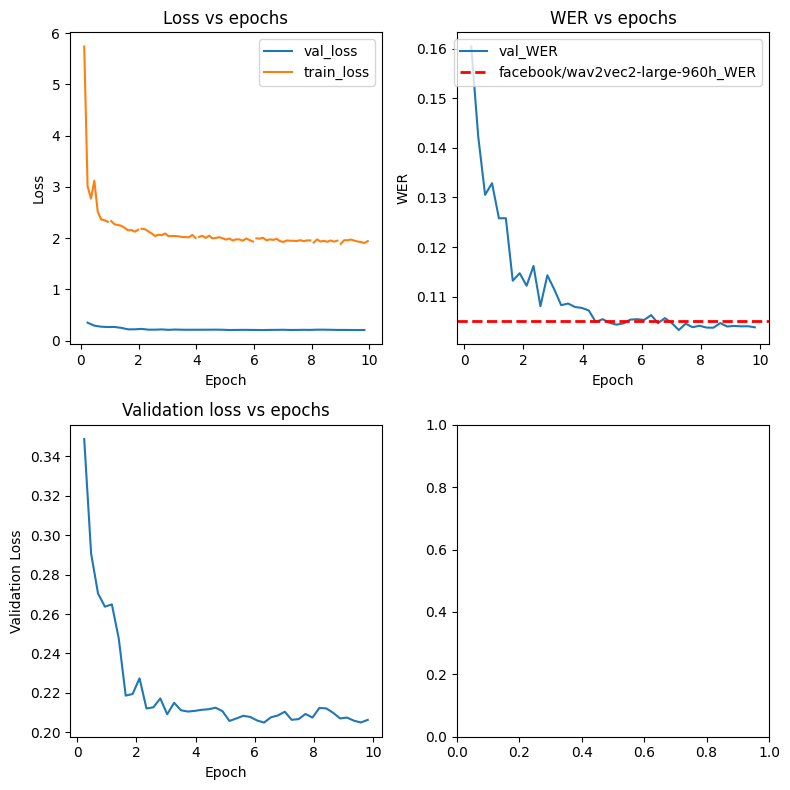

In [35]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.flatten()

axs[0].plot(df_eval['train/epoch'],df_eval['eval/loss'],label='val_loss')
axs[0].plot(df['train/epoch'],df['train/loss'],label='train_loss')
axs[0].set_title('Loss vs epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(df_eval['train/epoch'],df_eval['eval/wer'],label='val_WER')
axs[1].axhline(y=0.105, color='red', linestyle='--', linewidth=2, label='facebook/wav2vec2-large-960h_WER')
axs[1].set_title('WER vs epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('WER')
axs[1].legend()

axs[2].plot(df_eval['train/epoch'],df_eval['eval/loss'])
axs[2].set_title('Validation loss vs epochs')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Validation Loss')

fig.tight_layout()

As shown above, the training loss curve begins flattening quickly, within 2 epochs. For better visibility, we replot the validation loss in the lower left plot, showing the same trend. This implies that we could have stopped the training much earlier, perhaps within 4 epochs. According to the WER curve in the top right plot, the validation WER falls rapidly and stabilizes at a level similar to pre-finetuned levels showing that finetuning has brought little improvement. The implication of this finding is further explored in the next section.

At this point, we identify the model checkpoint with the lowest WER to save as our final, finetuned model.

In [36]:
df_eval.loc[df_eval['eval/wer']==df_eval['eval/wer'].min(),:]

tag,step,eval/loss,eval/runtime,eval/samples_per_second,eval/steps_per_second,eval/wer,train/epoch,train/grad_norm,train/learning_rate,train/loss,train/total_flos,train/train_loss,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second
65,15500,0.206327,388.355408,150.929001,9.435,0.103256,7.253159,2.619667,0.000005,1.9486,NaN,NaN,NaN,NaN,NaN


In [37]:
checkpoint_dir = os.path.expanduser('~/asr_project/asr-train/model_outputs/checkpoint-15500')  # Use the latest checkpoint path
model = Wav2Vec2ForCTC.from_pretrained(checkpoint_dir)

# Save model
tuned_model_path = os.path.join(
    HOME_DIR,
    'asr_project/asr-train/wav2vec2-large-960h-cv')
model.save_pretrained(tuned_model_path)

### Evaluation - cv-valid-test

We evaluate the performance of our model on the `cv-valid-test` set below. We follow the same preprocessing steps as before.

In [ ]:
# Test set directories
audio_or_dir = os.path.join(HOME_DIR,'asr_project/common_voice/cv-valid-test/')
audio_dir = os.path.join(HOME_DIR,'asr_project/common_voice/cv-valid-test/cv-valid-test/')
audioloc_transcript_or_dir = os.path.join(HOME_DIR,'asr_project/common_voice/cv-valid-test.csv')
audioloc_transcript_dir = os.path.join(HOME_DIR,'asr_project/asr-train/selected_transcript-test.csv')
temp_dir = os.path.join(HOME_DIR,'asr_project/asr-train/temp-test.csv')

df = pd.read_csv(audioloc_transcript_or_dir)

# Convert mp3 to wav. Change mp3 file extension in df accordingly
df['filename'] = df['filename'].apply(
    lambda filename: convert_mp3_to_wav(
        os.path.join(audio_or_dir, filename)))

# Put texts to uppercase to match pre-finetuned model
df['text'] = df['text'].str.upper()
df['filename'] = df['filename'].map(lambda x: os.path.basename(x))

df_transcript = df[['filename','text']]
df_transcript.to_csv(audioloc_transcript_dir,index=False)

In [ ]:
# Load csv file with wav filenames, complete path and create dataset
df = pd.read_csv(audioloc_transcript_dir)
df['filename'] = df['filename'].map(lambda x: os.path.join(audio_dir,x))
df.to_csv(temp_dir,index=False)

dataset = load_dataset('csv', data_files=temp_dir, split='train')
dataset = dataset.cast_column("filename",
                              Audio(sampling_rate=16000))         # Cast audio files with 16kHz sampling rate

# Following the style of facebook/wav2ec2-large-960h model
start_token = "<s>"
end_token = "</s>"
word_delimiter_token = "|"

# Define the preprocessing function
def preprocess_transcript(example):
    transcript = example['text']  # Assuming the column with text is named 'text'
    
    # Step 1: Replace multiple spaces with a single space
    transcript = re.sub(r'\s+', ' ', transcript)  # Remove extra spaces
    
    # Step 2: Add start and end tokens, and replace spaces with '|'
    processed_transcript = start_token + transcript.replace(" ", f"{word_delimiter_token}") + end_token
    
    return {"processed_text": processed_transcript}  # Return the processed text in a dictionary

# Apply the preprocessing to both train and validation splits
dataset = dataset.map(preprocess_transcript, remove_columns=["text"],num_proc=4)

dataset = dataset.rename_column("filename", "input_values")
dataset = dataset.rename_column("processed_text", "labels")

def prepare_dataset(batch):
    # Process 'input_values' column for 1D waveform values
    batch["input_values"] = processor(batch["input_values"]["array"],
                                      sampling_rate=16000).input_values[0]
    
    # Process the 'labels' column to create 'labels' (text data)
    batch["labels"] = processor(text=batch["labels"]).input_ids
    
    return batch

# Map the dataset transformation to both 'train' and 'val' splits
dataset = dataset.map(prepare_dataset, num_proc=2)

dataset

Generating train split: 3995 examples [00:00, 368374.36 examples/s]
Map (num_proc=2): 100%|██████████| 3995/3995 [00:04<00:00, 847.69 examples/s] 


Dataset({
    features: ['input_values', 'labels'],
    num_rows: 3995
})

We calculate the WER, getting ***9.8% WER for our finetuned model*** against `cv-valid-test.csv`.

In [ ]:
# Load finetuned model
model = Wav2Vec2ForCTC.from_pretrained(tuned_model_path)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

model.to('cuda')
results = dataset.map(map_to_result, remove_columns=dataset.column_names)

# Apply the function to the entire dataset
results = results.map(remove_start_end_tags_batch)

print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Map: 100%|██████████| 3995/3995 [00:00<00:00, 66559.06 examples/s]

Test WER: 0.098


For completeness sake, we check the WER for the pre-finetuned model, getting a WER of 10.3%.

In [ ]:
# Load model
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

def map_to_result(batch):
    with torch.no_grad():
        input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
        logits = model(input_values).logits

    pred_ids = torch.argmax(logits, dim=-1)
    batch["pred_str"] = processor.batch_decode(pred_ids)[0]
    batch["text"] = processor.decode(batch["labels"], group_tokens=False)
  
    return batch

model.to('cuda')
results = dataset.map(map_to_result, remove_columns=dataset.column_names)
# Apply the function to the entire dataset
results = results.map(remove_start_end_tags_batch)

print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 3995/3995 [00:00<00:00, 69076.27 examples/s]

Test WER: 0.103


### Evaluation - cv-valid-dev

We evaluate the performance of our model on the `cv-valid-dev` set below. We follow the same preprocessing steps as before. The discussion for this part of the notebook is available as a pdf in `asr_project/training-report.pdf`, following assignment requirements.

In [ ]:
# Test set directories
audio_or_dir = os.path.join(HOME_DIR,'asr_project/common_voice/cv-valid-dev/')
audio_dir = os.path.join(HOME_DIR,'asr_project/common_voice/cv-valid-dev/cv-valid-dev/')
audioloc_transcript_or_dir = os.path.join(HOME_DIR,'asr_project/common_voice/cv-valid-dev.csv')
audioloc_transcript_dir = os.path.join(HOME_DIR,'asr_project/asr-train/selected_transcript-dev.csv')
temp_dir = os.path.join(HOME_DIR,'asr_project/asr-train/temp-dev.csv')

df = pd.read_csv(audioloc_transcript_or_dir)

# Convert mp3 to wav. Change mp3 file extension in df accordingly
df['filename'] = df['filename'].apply(
    lambda filename: convert_mp3_to_wav(
        os.path.join(audio_or_dir, filename)))

# Put texts to uppercase to match pre-finetuned model
df['text'] = df['text'].str.upper()
df['filename'] = df['filename'].map(lambda x: os.path.basename(x))

df_transcript = df[['filename','text']]
df_transcript.to_csv(audioloc_transcript_dir,index=False)

In [ ]:
# Load csv file with wav filenames, complete path and create dataset
df = pd.read_csv(audioloc_transcript_dir)
df['filename'] = df['filename'].map(lambda x: os.path.join(audio_dir,x))
df.to_csv(temp_dir,index=False)

dataset = load_dataset('csv', data_files=temp_dir, split='train')
dataset = dataset.cast_column("filename",
                              Audio(sampling_rate=16000))         # Cast audio files with 16kHz sampling rate

# Following the style of facebook/wav2ec2-large-960h model
start_token = "<s>"
end_token = "</s>"
word_delimiter_token = "|"

# Define the preprocessing function
def preprocess_transcript(example):
    transcript = example['text']  # Assuming the column with text is named 'text'
    
    # Step 1: Replace multiple spaces with a single space
    transcript = re.sub(r'\s+', ' ', transcript)  # Remove extra spaces
    
    # Step 2: Add start and end tokens, and replace spaces with '|'
    processed_transcript = start_token + transcript.replace(" ", f"{word_delimiter_token}") + end_token
    
    return {"processed_text": processed_transcript}  # Return the processed text in a dictionary

# Apply the preprocessing to both train and validation splits
dataset = dataset.map(preprocess_transcript, remove_columns=["text"],num_proc=4)

dataset = dataset.rename_column("filename", "input_values")
dataset = dataset.rename_column("processed_text", "labels")

def prepare_dataset(batch):
    # Process 'input_values' column for 1D waveform values
    batch["input_values"] = processor(batch["input_values"]["array"],
                                      sampling_rate=16000).input_values[0]
    
    # Process the 'labels' column to create 'labels' (text data)
    batch["labels"] = processor(text=batch["labels"]).input_ids
    
    return batch

# Map the dataset transformation to both 'train' and 'val' splits
dataset = dataset.map(prepare_dataset, num_proc=2)

dataset

Generating train split: 4076 examples [00:00, 226926.78 examples/s]
Map (num_proc=2): 100%|██████████| 4076/4076 [00:04<00:00, 915.54 examples/s] 


Dataset({
    features: ['input_values', 'labels'],
    num_rows: 4076
})

We calculate the WER, getting 10.4% WER for our finetuned model.

In [ ]:
# Load finetuned model
model = Wav2Vec2ForCTC.from_pretrained(tuned_model_path)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

model.to('cuda')
results = dataset.map(map_to_result, remove_columns=dataset.column_names)

# Apply the function to the entire dataset
results = results.map(remove_start_end_tags_batch)

print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Map: 100%|██████████| 4076/4076 [00:00<00:00, 67364.04 examples/s]

Test WER: 0.104


We check the WER for the pre-finetuned model, getting a WER of 10.8%.

In [ ]:
# Load model
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

def map_to_result(batch):
    with torch.no_grad():
        input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
        logits = model(input_values).logits

    pred_ids = torch.argmax(logits, dim=-1)
    batch["pred_str"] = processor.batch_decode(pred_ids)[0]
    batch["text"] = processor.decode(batch["labels"], group_tokens=False)
  
    return batch

model.to('cuda')
results = dataset.map(map_to_result, remove_columns=dataset.column_names)
# Apply the function to the entire dataset
results = results.map(remove_start_end_tags_batch)

print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 4076/4076 [00:00<00:00, 55967.08 examples/s]

Test WER: 0.108
